## K-means Clustering Using PCA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [4]:
# load Kaggle species data
species = pd.read_csv('species.csv')

# add a park code column for future merging
species['Park Code'] = species['Species ID'].str[:4]
species['Park Name'] = species['Park Name'].map(lambda x: x.rstrip('and Preserve'))
species.head()

/var/folders/vb/bprs19k12d92r7xpmxnv1rx40000gn/T/ipykernel_42548/2178265331.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv('species.csv')


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13,Park Code
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN,ACAD
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN,ACAD
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN,ACAD
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN,ACAD
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN,ACAD


In [9]:
# load location data for each park

locations = pd.read_csv('parks_update.csv')

In [24]:
import openpyxl

# adding missing parks 
viis = pd.read_excel('viis_sp.xlsx')
whsa = pd.read_excel('whsa_sp.xlsx')
npsa = pd.read_excel('npsa_sp.xlsx')
neri = pd.read_excel('neri_sp.xlsx')
indu = pd.read_excel('indu_sp.xlsx')

rel_columns = ['Park Name', 'Category', 'Order', 'Family', 'Scientific Name', 'Common Names', 'Record Status', 'Occurrence', 'Abundance', 'Park Code']
viis = viis[rel_columns]
whsa = whsa[rel_columns]
npsa = npsa[rel_columns]
neri = neri[rel_columns]
indu = indu[rel_columns]

In [25]:
species = species.append([viis, whsa, npsa, neri, indu])
species.head()

/var/folders/vb/bprs19k12d92r7xpmxnv1rx40000gn/T/ipykernel_42548/2263228394.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species = species.append([viis, whsa, npsa, neri, indu])


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13,Park Code
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN,ACAD
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN,ACAD
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN,ACAD
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN,ACAD
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN,ACAD


In [10]:
# new df with only species that are present 
present_sp = species[species['Occurrence'] == 'Present']

abundance_df = present_sp[['Park Name', 'Scientific Name', 'Abundance', 'Occurrence']]
abundance_df['Abundance'].value_counts()

Unknown       31492
Uncommon      20406
Common        14437
Rare          11659
Occasional     3505
Abundant       2676
Name: Abundance, dtype: int64

#### Calculating Cosine Similarity between Parks

In [11]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]

p_code1 = 'REDW'
p_code2 = 'YOSE'

# calculate cosine distances (1 - cosine similarity)
def getCosineSim(park1, park2):
    
    # get species present in park
    cos_park1 = list(similarity_df[similarity_df['Park Code'] == park1]['Scientific Name'])
    cos_park2 = list(similarity_df[similarity_df['Park Code'] == park2]['Scientific Name'])
    
    # count species 
    vals_1 = Counter(cos_park1)
    vals_2 = Counter(cos_park2)

    # list of all words from park 1 and park 2
    words  = list(vals_1.keys() | vals_2.keys())

    # convert list of species to vectors (0 if absent in park, 1 if present in park)
    vect_1 = [vals_1.get(word, 0) for word in words]       
    vect_2 = [vals_2.get(word, 0) for word in words] 
    
    # return cosine distance (1 - cosine sim)
    return 1- round(cosine_similarity([vect_1], [vect_2])[0][0], 4)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

In [13]:
# like of all park codes
park_codes = list(similarity_df['Park Code'].unique())

# list of all species in a park
code_sp_list = []
for code in park_codes:
    sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
    #sp.append(code)
    code_sp_list.append(sp)

# new park-species dataframe
park_sp_df = pd.DataFrame()
park_sp_df['park_code'] = park_codes
park_sp_df['species_list'] = code_sp_list
park_sp_df.head()

,park_code,species_list
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la..."
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu..."
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana..."
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi..."
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent..."


In [14]:
# 0 if species is not present, 1 if species is present
mlb = MultiLabelBinarizer()
vec = mlb.fit_transform(park_sp_df['species_list'])
vecs = pd.DataFrame(vec, columns=mlb.classes_)
vecs

,Abacidus,Abaeis nicippe,Abagrotis placida,Abedus,Abedus indentatus,Abelia X grandiflora,Abgrallaspis cyanophylli,Abies X shastensis,Abies amabilis,Abies balsamea,...,Zuckia brandegei var. plummeri,Zygodon reinwardtii,Zygodon rubrigemmius,Zygodon tetragonostomus,Zygodon viridissimus,Zygodon viridissimus var. rupestris,"nr. Bledius, sp.111",nr. Cercyon sp. 26,ormosia scleroprocta,physa virgata
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# apply cosine_similarity fxn on df
df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

# pca for dimensitonality reduction
pca = PCA(4)
transform = pca.fit_transform(df_cosine)
transform

array([[ 3.16991382e-01,  2.16149199e-01,  6.91233658e-01,
        -4.72619234e-02],
       [-9.06757925e-01, -3.27203280e-01, -3.64626231e-02,
        -2.91729267e-01],
       [-4.34962309e-01, -8.49599070e-02,  3.25252835e-01,
        -1.72077323e-01],
       [-5.57627551e-01,  1.82204562e-01, -1.70636461e-01,
        -3.85090735e-01],
       [ 2.10396411e-01,  8.78292459e-01, -5.23651821e-01,
        -2.23140640e-01],
       [-5.78018382e-01, -2.49770075e-01, -8.46306368e-02,
         4.39298990e-02],
       [-7.49015372e-01, -4.12278635e-01, -5.17483860e-02,
        -5.93164849e-02],
       [-9.39655803e-01, -3.69845732e-01, -7.18044966e-02,
        -3.02291962e-01],
       [-9.23612145e-01, -4.26348912e-01,  2.30918001e-02,
        -2.60180056e-01],
       [-7.53133828e-01,  2.15360996e-02, -6.50424753e-02,
        -4.46511836e-01],
       [-8.89305539e-02,  1.78448633e-01, -2.88022170e-01,
         1.22503655e-01],
       [ 1.91992642e-01,  8.50619000e-01,  2.05920430e-01,
      

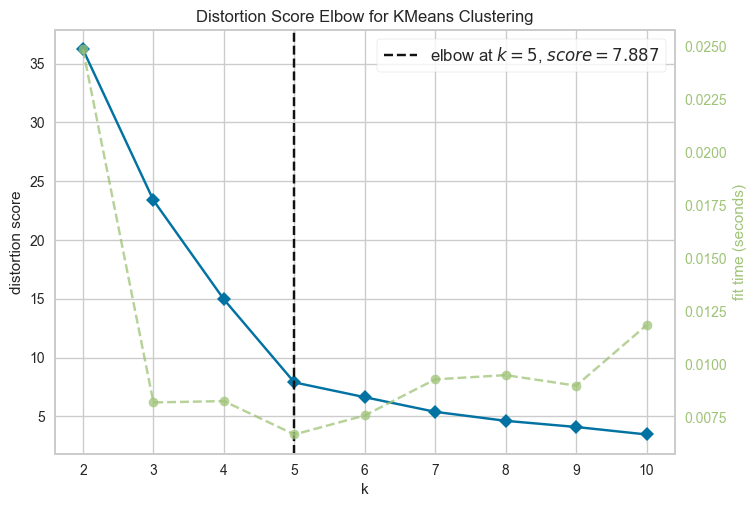

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# elbow plot
import yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11))

visualizer.fit(transform) # Fit the data to the visualizer
visualizer.show()

### K-means Clustering

In [18]:
k_means = KMeans(n_clusters=5, random_state = 42)

# get cluster labels for each park
label = k_means.fit_predict(transform)

u_labels = np.unique(label)

# add cluster label to park
park_sp_df['k_cluster'] = label

k_clus_loc = park_sp_df.merge(locations, how = 'left', left_on = 'park_code', right_on = 'Park Code')
k_clus_loc

,park_code,species_list,k_cluster,Park Code,Park Name,State,Acres,Latitude,Longitude,present
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la...",0,ACAD,Acadia National Park,ME,47390,44.3500,-68.2100,1
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu...",1,ARCH,Arches National Park,UT,76519,38.6800,-109.5700,1
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana...",1,BADL,Badlands National Park,SD,242756,43.7500,-102.5000,1
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi...",1,BIBE,Big Bend National Park,TX,801163,29.2500,-103.2500,1
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent...",4,BISC,Biscayne National Park,FL,172924,25.6500,-80.0800,1
...,...,...,...,...,...,...,...,...,...,...
56,VIIS,"[Capra hircus, Odocoileus virginianus, Sus scr...",4,VIIS,Virgin Islands National Park,VI,12909,18.3435,64.7501,0
57,WHSA,"[Antilocapra americana, Oryx gazella, Odocoile...",1,WHSA,White Sands National Park,NM,73600,32.7872,-106.3257,0
58,NPSA,"[Sus scrofa, Felis catus, Megaptera novaeangli...",4,NPSA,National Park of American Samoa,AS,13500,14.2583,170.6833,0
59,NERI,"[Odocoileus virginianus, Canis latrans, Canis ...",0,NERI,New River Gorge National Park,WV,72808,37.8752,-81.0357,0


In [19]:
import folium 

location_list = k_clus_loc[['Latitude', 'Longitude']].values.tolist()
park_names = k_clus_loc['Park Name'].tolist()

# assign colors to each cluster
def regioncolors(counter):
    if counter['k_cluster'] == 0:
        return 'darkblue'
    elif counter['k_cluster'] == 1:
        return 'darkred'
    elif counter['k_cluster'] == 2:
        return 'blue'
    elif counter['k_cluster'] == 3:
        return 'darkgreen'
    else:
        return 'darkpurple'
        
k_clus_loc['color'] = k_clus_loc.apply(regioncolors, axis = 1)
k_clus_loc[k_clus_loc['k_cluster'] == 4]
k_clus_loc = k_clus_loc.dropna()

In [20]:
us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)

for point in range(0, len(location_list)):
    folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=k_clus_loc["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)

display(us_map)

### Evaluation

In [21]:
from sklearn.metrics import silhouette_score

silhouette_score(transform, k_means.fit_predict(transform)) # a good silhouette score should be > 0.5

0.5606161269887896

Silhouette Score for k =  2 is 0.28613874906828074
Silhouette Score for k =  3 is 0.4053832511752042
Silhouette Score for k =  4 is 0.47236029194201207
Silhouette Score for k =  5 is 0.5606161269887896
Silhouette Score for k =  6 is 0.5482662942704468
Silhouette Score for k =  7 is 0.5031124509760896
Silhouette Score for k =  8 is 0.50707519679975
Silhouette Score for k =  9 is 0.5004526124317779
Silhouette Score for k =  10 is 0.48905024763397076


Text(0, 0.5, 'Silhouette score')

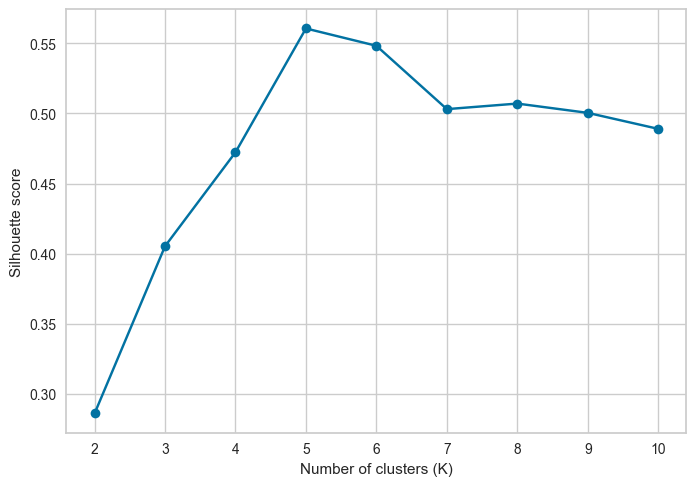

In [22]:
silhouette_scores = []

for k in range(2, 11):
    model2 = KMeans(n_clusters=k, random_state=42)
    model2.fit(transform)
    score = silhouette_score(transform, model2.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

Text(0.5, 1.0, 'K-means Clusters')

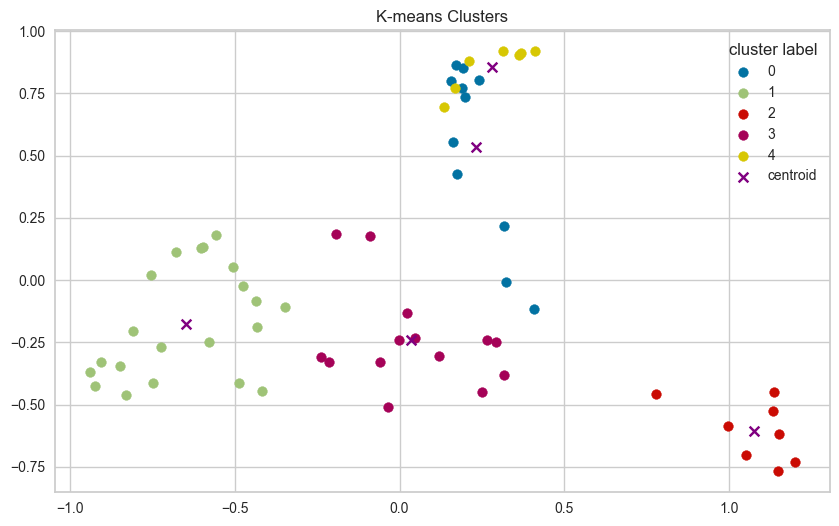

In [23]:
colors = ['darkblue', 'darkred', 'blue', 'darkgreen', 'purple']
plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='purple',marker='x',label='centroid')
plt.legend(title = 'cluster label')
plt.title('K-means Clusters')